<a href="https://colab.research.google.com/github/miladrezazadeh/UV-Vis-PL-to-bandgaps/blob/main/UV_VIS_To_TAUC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/UV-Vis-to-Tauc')

In [ ]:
## Import required libraries
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import pickle
import matplotlib.pyplot as plt
import matplotlib.cbook
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("always")
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

## UV-Vis to Tauc 

In [ ]:
## Reading the input file for UV-Vis
UV_df = pd.read_excel('/content/drive/MyDrive/UV-Vis-to-Tauc/RAW_DATA_ABS/2Day-ABS.xlsx', header=None)

In [ ]:
## Assigning names for each columns
#df.columns=["P"+str(i) for i in range(1, len(df.columns) + 1)]
UV_df.rename(columns={0: 'wavelength'}, inplace=True)

In [ ]:
UV_df

,wavelength,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228
0,500.214600,0.071867,0.075035,0.071068,0.066308,0.074318,0.066897,0.071040,0.071235,0.072514,0.070007,0.071841,0.071440,0.071637,0.083147,0.089579,0.085469,0.084289,0.072384,0.085110,0.079373,0.067558,0.083171,0.077882,0.078518,0.075431,0.081302,0.092008,0.099169,0.087256,0.073820,0.088327,0.086052,0.076817,0.077306,0.086922,0.076785,0.074958,0.068586,0.069305,...,0.155627,0.144473,0.143035,0.140324,0.143355,0.128380,0.145164,0.144749,0.130187,0.129876,0.127583,0.127245,0.125065,0.115127,0.104756,0.118705,0.124943,0.126400,0.130007,0.125254,0.127074,0.128104,0.131392,0.126404,0.123583,0.127961,0.126602,0.132229,0.130078,0.128125,0.127123,0.129021,0.132993,0.135429,0.127123,0.115401,0.111439,0.119551,0.125789,0.119883
1,500.800598,0.072099,0.075298,0.071352,0.066583,0.074565,0.067205,0.071398,0.071588,0.072871,0.070344,0.072153,0.071786,0.071945,0.083473,0.089938,0.085774,0.084617,0.072715,0.085435,0.079732,0.067933,0.083504,0.078251,0.078845,0.075789,0.081647,0.092354,0.099543,0.087622,0.074195,0.088681,0.086414,0.077185,0.077631,0.087261,0.077161,0.075331,0.068960,0.069664,...,0.155748,0.144546,0.143138,0.140394,0.143441,0.128474,0.145265,0.144844,0.130308,0.129954,0.127689,0.127320,0.125146,0.115232,0.104829,0.118774,0.125044,0.126479,0.130102,0.125350,0.127155,0.128196,0.131486,0.126498,0.123712,0.128040,0.126660,0.132347,0.130194,0.128195,0.127222,0.129111,0.133110,0.135528,0.127182,0.115451,0.111515,0.119576,0.125840,0.119939
2,501.386536,0.072312,0.075516,0.071593,0.066832,0.074781,0.067434,0.071712,0.071922,0.073163,0.070654,0.072454,0.072076,0.072231,0.083739,0.090252,0.086049,0.084900,0.072990,0.085711,0.080010,0.068228,0.083812,0.078587,0.079115,0.076080,0.081923,0.092645,0.099847,0.087928,0.074525,0.088971,0.086733,0.077496,0.077919,0.087559,0.077463,0.075613,0.069255,0.069974,...,0.155838,0.144606,0.143201,0.140412,0.143465,0.128518,0.145309,0.144883,0.130377,0.130037,0.127747,0.127334,0.125182,0.115252,0.104859,0.118790,0.125088,0.126507,0.130165,0.125394,0.127202,0.128261,0.131550,0.126534,0.123761,0.128108,0.126710,0.132378,0.130230,0.128251,0.127277,0.129178,0.133167,0.135585,0.127219,0.115456,0.111553,0.119602,0.125851,0.119941
3,501.972443,0.072514,0.075725,0.071816,0.067048,0.074969,0.067669,0.071970,0.072198,0.073433,0.070902,0.072666,0.072303,0.072488,0.083956,0.090522,0.086276,0.085105,0.073228,0.085948,0.080230,0.068478,0.084051,0.078864,0.079342,0.076337,0.082145,0.092871,0.100093,0.088135,0.074773,0.089178,0.087007,0.077745,0.078138,0.087773,0.077709,0.075863,0.069478,0.070235,...,0.155864,0.144638,0.143217,0.140384,0.143474,0.128512,0.145328,0.144868,0.130404,0.130056,0.127745,0.127331,0.125178,0.115227,0.104818,0.118775,0.125080,0.126511,0.130157,0.125418,0.127189,0.128259,0.131565,0.126543,0.123791,0.128114,0.126729,0.132396,0.130261,0.128295,0.127298,0.129203,0.133189,0.135571,0.127197,0.115421,0.111558,0.119604,0.125857,0.119920
4,502.558350,0.072720,0.075926,0.072021,0.067254,0.075136,0.067896,0.072191,0.072448,0.073673,0.071151,0.072887,0.072524,0.072723,0.084160,0.090734,0.086473,0.085312,0.073433,0.086152,0.080419,0.068683,0.084256,0.079137,0.079576,0.076576,0.082360,0.093110,0.100312,0.088363,0.074984,0.089383,0.087211,0.077989,0.078348,0.087970,0.077933,0.076101,0.069720,0.070482,...,0.155903,0.144637,0.143204,0.140390,0.143457,0.128512,0.145325,0.144883,0.130396,0.130061,0.127738,0.127327,0.125139,0.115189,0.104775,0.118731,0.125066,0.126468,0.130143,0.125404,0.127184,0.128260,0.131556,0.126536,0.123800,0.128126,0.126734,0.132407,0.130292,0.128295,0.127304,0.129240,0.133187,0.135559,0.127189,0.115387,0.111531,0.119583,0.125831,0.119892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
## Create UV-vis plot for all the columns
def ABS_plot(df):
  y_columns = df.columns[2:]
  from itertools import cycle
  cycol = cycle('bgrcmk')
  ax = df.plot.scatter(x=df.columns[0], y=df.columns[1])
  for y_col in y_columns:
    df.plot.scatter(x = df.columns[0], y = y_col, c=next(cycol), ax=ax);
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Absorbance")

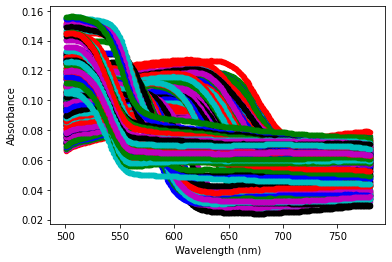

In [ ]:
## Plot raw data
ABS_plot(UV_df)

In [ ]:
## set all the data points before max to max
def max_min_correction(df):
  y_columns = df.columns[1:]
  for y_col in y_columns:
    max_idx = df[y_col].argmax()
    min_idx = df[y_col].argmin()
    max_val = df[y_col].iloc[max_idx]
    min_val = df[y_col].iloc[min_idx]
    df.loc[0:max_idx, y_col] = max_val
    #df.loc[0:min_idx, y_col] = min_val
  return df

In [ ]:
UV_df = max_min_correction(UV_df)

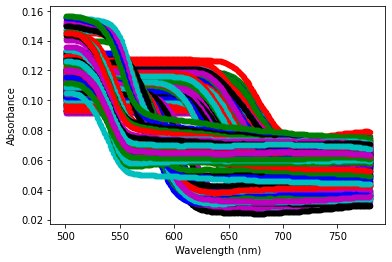

In [ ]:
## After max correction
ABS_plot(UV_df)

In [ ]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns[1:]:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [ ]:
UV_df = normalize(UV_df)

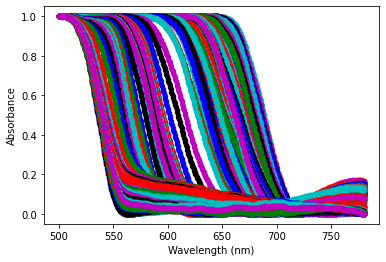

In [ ]:
## After normalization
ABS_plot(UV_df)

In [ ]:
## All the columns to the power of two
def scale(df):
  result = df.copy()
  for feature_name in df.columns[1:]:
    result[feature_name] = (df[feature_name] ** 2)
  return result

In [ ]:
UV_df = scale(UV_df)

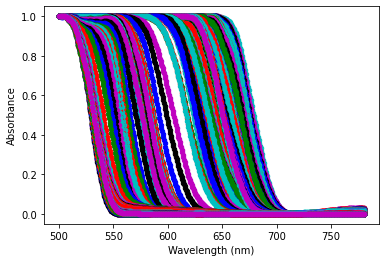

In [ ]:
## After scaling the columns to power of two
ABS_plot(UV_df)

In [ ]:
## Convert Wavelength column to photon energy
def Energy(df):
  df.rename(columns={'wavelength': 'Energy(eV)'}, inplace=True)
  df['Energy(eV)'] = 1240.0/df['Energy(eV)'] 
  return df

In [ ]:
Tauc_df = Energy(UV_df)

In [ ]:
## Create Tauc plot
def Tauc_Plot(df):
  y_columns = df.columns[2:]
  from itertools import cycle
  cycol = cycle('bgrcmk')
  ax = df.plot.scatter(x="Energy(eV)", y=df.columns[1])
  for y_col in y_columns:
    df.plot.scatter(x = "Energy(eV)", y = y_col, c=next(cycol), ax=ax);
    ax.set_xlabel("Energy (eV)")
    ax.set_ylabel("Absorbance")

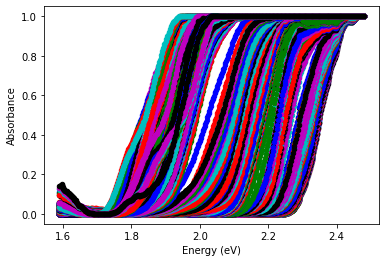

In [ ]:
Tauc_Plot(Tauc_df)

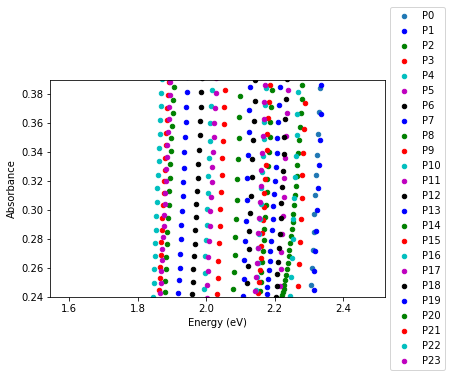

In [ ]:
# ## Part of Tauc plot
# y_columns = df.columns[2:]
# from itertools import cycle
# cycol = cycle('bgrcmk')
# ax = df.plot.scatter(x="Energy(eV)", y=df.columns[1], label=df.columns[1])
# for y_col in y_columns:
#     df.plot.scatter(x = "Energy(eV)", y = y_col, label="{}".format(y_col), c=next(cycol), ax=ax);
#     ax.set_ylim([0.24, 0.39])
#     ax.set_xlabel("Energy (eV)")
#     ax.set_ylabel("Absorbance")
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
# indicator_index = (df['P0'] >= 0.24) & (df['P0'] <= 0.39)
# print(indicator_index)

In [ ]:
# req_indices = df.index.values[indicator_index]
# print(req_indices)

In [ ]:
# df.loc[req_indices, 'P0']

In [ ]:
# df.loc[req_indices]

In [ ]:
bandgap = []
def trendline(xd, yd, order=1, c='r', alpha=1, Rval=False):
    """Make a line of best fit"""

    #Calculate trendline
    coeffs = np.polyfit(xd, yd, order)

    intercept = coeffs[-1]
    slope = coeffs[-2]
    power = coeffs[0] if order == 2 else 0

    minxd = np.min(xd)
    maxxd = np.max(xd)

    xl = np.array([minxd, maxxd])
    yl = power * xl ** 2 + slope * xl + intercept
    x_intercept = (-1*intercept) / slope
    # print(x_intercept)
    
    bandgap.append(x_intercept)
    
    #Plot trendline
    #plt.plot(xl, yl, c, alpha=alpha)
    #plt.title("Band gap = {}".format(x_intercept), fontweight="bold")
    #print("Band gap = ", x_intercept)
    #Calculate R Squared
    p = np.poly1d(coeffs)

    ybar = np.sum(yd) / len(yd)
    ssreg = np.sum((p(xd) - ybar) ** 2)
    sstot = np.sum((yd - ybar) ** 2)
    Rsqr = ssreg / sstot

    if not Rval:
        #Plot R^2 value
        plt.text(0.8 * maxxd + 0.2 * minxd, 0.8 * np.max(yd) + 0.2 * np.min(yd),
                 '$R^2 = %0.2f$' % Rsqr)
    else:
        #Return the R^2 value:
        return Rsqr

In [ ]:
def band_gap(df):
  y_columns = df.columns[1:]
  for y_col in y_columns:
    indicator_index = (df[y_col] >= 0.2) & (df[y_col] <= 0.4)
    req_indices = df.index.values[indicator_index]
    new_df = df.loc[req_indices,['Energy(eV)', y_col]]
    #new_df.plot.scatter(x = "Energy(eV)", y = y_col, label="{}".format(y_col))
    trendline( new_df.iloc[:,0], new_df.iloc[:,1] )

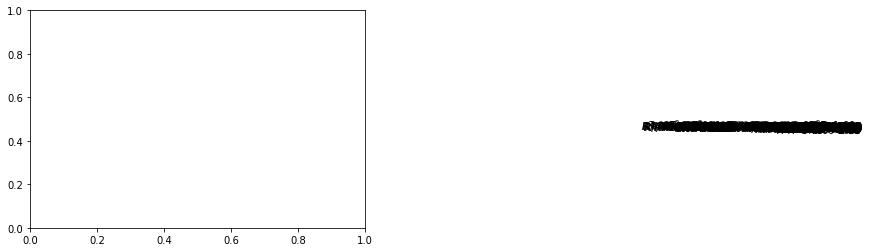

In [ ]:
band_gap(Tauc_df)

In [ ]:
## Exporting bandgaps as a new dataframe
def export(df):
  dict = {}
  y_columns = df.columns[1:]
  for i,y_col in enumerate(y_columns):
    dict[y_col] = bandgap[i]
  result = pd.DataFrame.from_dict(dict, orient='index').rename(columns={0:'Bandgap'})
  return result

In [ ]:
result = export(Tauc_df)
result

,Bandgap
1,2.259716
2,2.259651
3,2.263623
4,2.270575
5,2.274833
...,...
237,1.787604
238,1.785007
239,1.776252
240,1.775873


In [ ]:
result.to_excel('/content/drive/MyDrive/UV-Vis-to-Tauc/Results_ABS/4Day-ABS_Bandgap_results.xlsx')

## PL data

In [ ]:
## Reading the input file for PL
PL_df = pd.read_excel('/content/drive/MyDrive/UV-Vis-to-Tauc/2DayPL.xlsx', header=None)

In [ ]:
## Assigning names for each columns
#df.columns=["P"+str(i) for i in range(1, len(df.columns) + 1)]
PL_df.rename(columns={0: 'wavelength'}, inplace=True)

In [ ]:
PL_df

,wavelength,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97
0,500.214600,400.723236,389.774689,381.440979,378.374847,411.909454,415.584442,401.225922,429.337769,424.771393,421.088928,400.762054,403.016449,414.503082,413.097260,439.508789,418.615906,424.306488,390.271790,414.316040,398.065247,404.067810,397.528046,387.426086,404.253326,408.662750,418.256744,419.086945,415.336823,424.980225,400.566742,397.574036,404.923218,412.702637,402.454895,415.343536,455.453674,442.770599,438.840942,455.689331,...,400.440460,414.349823,398.419434,400.656647,398.163544,398.241394,402.792145,396.975677,393.167908,382.779022,395.169220,411.895630,404.066071,392.603668,395.438782,409.297241,424.430786,429.441681,398.842621,413.514801,468.198395,459.451385,503.160522,499.759827,497.048462,636.743042,568.441162,517.939758,496.783142,537.111877,506.111816,508.478271,498.144653,563.104614,510.639862,544.910645,523.022827,546.381348,473.198944,526.834534
1,500.800598,395.126465,384.636292,378.914490,374.094086,405.966187,410.031433,394.770447,421.591064,418.464050,415.439423,393.993469,395.659973,408.829926,406.178375,431.199280,412.674438,418.631836,385.426788,408.375275,393.642120,398.199860,393.638245,383.468903,398.682037,403.434357,413.279114,411.714386,410.283844,418.754028,395.628479,395.343964,399.245667,409.383148,396.900177,410.590637,447.997620,433.627655,433.474304,448.237976,...,395.546478,410.091064,392.785797,395.525818,394.128113,394.034149,396.954742,392.671600,390.614532,378.345062,390.957642,406.584320,399.850891,386.777649,391.980408,404.692169,420.020844,423.787476,395.821136,408.787048,459.641754,449.626068,496.310822,492.300049,486.809265,623.406616,556.616577,510.651062,490.446014,527.628784,499.530762,502.506989,493.026672,554.256042,502.766144,535.573914,513.661682,534.678345,464.300476,514.937134
2,501.386536,389.953125,383.497864,375.893494,372.069336,403.315521,407.161255,391.802734,418.083771,414.809662,410.030426,390.993134,393.859985,405.931610,401.942352,426.939636,407.654175,414.224365,381.238068,404.573059,391.267670,394.983734,392.368103,382.308716,397.335724,398.938721,409.598511,408.653259,407.461395,415.546539,393.183197,393.992554,394.840515,405.845947,393.466949,406.263153,442.175568,427.374817,430.911194,441.601288,...,393.014832,407.020599,389.782837,394.444794,391.100372,390.618408,390.677094,389.669006,388.964630,376.163818,388.380157,403.986969,397.378479,385.697723,390.116272,403.853180,416.669617,420.095551,393.449280,408.071503,455.023010,444.666595,490.741608,487.268158,479.189758,610.298584,549.972656,507.520874,486.193115,523.545837,496.936401,500.644348,488.823303,547.245544,500.513245,529.783630,506.871460,526.815674,456.706848,506.292480
3,501.972443,388.200226,382.587891,374.817383,371.216583,401.332397,404.958618,388.551300,414.006134,410.464508,406.098358,390.018402,390.465271,404.342560,398.666534,423.053284,403.577301,410.778564,379.378418,401.570892,387.911133,392.614960,391.468079,379.323395,395.999756,396.947266,407.792358,408.568848,405.333557,412.169464,390.241089,393.299194,392.614014,405.118103,391.416046,402.836945,437.608856,424.580139,427.378967,437.946991,...,391.255310,405.507263,390.445465,392.428986,391.201904,391.059113,387.199371,388.550232,386.639252,374.052612,385.616547,399.877289,396.460846,384.631470,388.297729,403.009460,415.850311,417.885254,392.772491,404.982361,453.373657,440.748199,485.335419,482.812408,474.224091,599.650757,544.787537,504.285400,483.616943,520.628967,496.555359,499.190125,485.343933,541.524536,498.522430,524.939941,501.613129,521.263916,451.276245,500.156860
4,502.558350,385.986725,380.308350,373.339661,369.150940,396.760193,401.386414,384.613220,409.480652,406.158020,400.475830,387.294220,387.403229,401.450714,394.435791,419.627930,400.612305,407.474152,376.414917,3

In [ ]:
## Create PL plot for all the columns
def PL_plot(df):
  y_columns = df.columns[2:]
  from itertools import cycle
  cycol = cycle('bgrcmk')
  ax = df.plot.scatter(x="wavelength", y=df.columns[1])
  for y_col in y_columns:
    df.plot.scatter(x = "wavelength", y = y_col, c=next(cycol), ax=ax);
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Photoluminescence intensity")

In [ ]:
from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve

## Original code source: https://github.com/zmzhang/airPLS/blob/master/airPLS.py
## publication: Z.-M. Zhang, S. Chen, and Y.-Z. Liang, Baseline correction using adaptive iteratively reweighted penalized least squares. Analyst 135 (5), 1138-1146 (2010).

def WhittakerSmooth(x,w,lambda_,differences=1):
    '''
    Penalized least squares algorithm for background fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        w: binary masks (value of the mask is zero if a point belongs to peaks and one otherwise)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background
        differences: integer indicating the order of the difference of penalties
    
    output
        the fitted background vector
    '''
    X=np.matrix(x)
    m=X.size
    i=np.arange(0,m)
    E=eye(m,format='csc')
    D=E[1:]-E[:-1] # numpy.diff() does not work with sparse matrix. This is a workaround.
    W=diags(w,0,shape=(m,m))
    A=csc_matrix(W+(lambda_*D.T*D))
    B=csc_matrix(W*X.T)
    background=spsolve(A,B)
    return np.array(background)



In [ ]:
def airPLS(x, lambda_=100, porder=1, itermax=15):
    '''
    Adaptive iteratively reweighted penalized least squares for baseline fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background, z
        porder: adaptive iteratively reweighted penalized least squares for baseline fitting
    
    output
        the fitted background vector
    '''
    m=x.shape[0]
    w=np.ones(m)
    for i in range(1,itermax+1):
        z=WhittakerSmooth(x,w,lambda_, porder)
        d=x-z
        dssn=np.abs(d[d<0].sum())
        if(dssn<0.001*(abs(x)).sum() or i==itermax):
            if(i==itermax): print('WARING max iteration reached!')
            break
        w[d>=0]=0 # d>0 means that this point is part of a peak, so its weight is set to 0 in order to ignore it
        w[d<0]=np.exp(i*np.abs(d[d<0])/dssn)
        w[0]=np.exp(i*(d[d<0]).max()/dssn) 
        w[-1]=w[0]
    return z

In [ ]:
#ax = PL_df.plot.scatter(x="wavelength", y=PL_df.columns[1])

In [ ]:
## Example of Baseline corrections for PL data

# from scipy.stats import norm
# y1 = PL_df[5]

# x = PL_df['wavelength']
# c1 = y1-airPLS(y1)

# fig,ax=plt.subplots(nrows=2,ncols=1)
# ax[0].plot(x,y1,'-k')
# ax[0].plot(x,c1,'-r')
# ax[0].set_title('baseline correction')


In [ ]:
PL_df

,wavelength,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97
0,500.214600,400.723236,389.774689,381.440979,378.374847,411.909454,415.584442,401.225922,429.337769,424.771393,421.088928,400.762054,403.016449,414.503082,413.097260,439.508789,418.615906,424.306488,390.271790,414.316040,398.065247,404.067810,397.528046,387.426086,404.253326,408.662750,418.256744,419.086945,415.336823,424.980225,400.566742,397.574036,404.923218,412.702637,402.454895,415.343536,455.453674,442.770599,438.840942,455.689331,...,400.440460,414.349823,398.419434,400.656647,398.163544,398.241394,402.792145,396.975677,393.167908,382.779022,395.169220,411.895630,404.066071,392.603668,395.438782,409.297241,424.430786,429.441681,398.842621,413.514801,468.198395,459.451385,503.160522,499.759827,497.048462,636.743042,568.441162,517.939758,496.783142,537.111877,506.111816,508.478271,498.144653,563.104614,510.639862,544.910645,523.022827,546.381348,473.198944,526.834534
1,500.800598,395.126465,384.636292,378.914490,374.094086,405.966187,410.031433,394.770447,421.591064,418.464050,415.439423,393.993469,395.659973,408.829926,406.178375,431.199280,412.674438,418.631836,385.426788,408.375275,393.642120,398.199860,393.638245,383.468903,398.682037,403.434357,413.279114,411.714386,410.283844,418.754028,395.628479,395.343964,399.245667,409.383148,396.900177,410.590637,447.997620,433.627655,433.474304,448.237976,...,395.546478,410.091064,392.785797,395.525818,394.128113,394.034149,396.954742,392.671600,390.614532,378.345062,390.957642,406.584320,399.850891,386.777649,391.980408,404.692169,420.020844,423.787476,395.821136,408.787048,459.641754,449.626068,496.310822,492.300049,486.809265,623.406616,556.616577,510.651062,490.446014,527.628784,499.530762,502.506989,493.026672,554.256042,502.766144,535.573914,513.661682,534.678345,464.300476,514.937134
2,501.386536,389.953125,383.497864,375.893494,372.069336,403.315521,407.161255,391.802734,418.083771,414.809662,410.030426,390.993134,393.859985,405.931610,401.942352,426.939636,407.654175,414.224365,381.238068,404.573059,391.267670,394.983734,392.368103,382.308716,397.335724,398.938721,409.598511,408.653259,407.461395,415.546539,393.183197,393.992554,394.840515,405.845947,393.466949,406.263153,442.175568,427.374817,430.911194,441.601288,...,393.014832,407.020599,389.782837,394.444794,391.100372,390.618408,390.677094,389.669006,388.964630,376.163818,388.380157,403.986969,397.378479,385.697723,390.116272,403.853180,416.669617,420.095551,393.449280,408.071503,455.023010,444.666595,490.741608,487.268158,479.189758,610.298584,549.972656,507.520874,486.193115,523.545837,496.936401,500.644348,488.823303,547.245544,500.513245,529.783630,506.871460,526.815674,456.706848,506.292480
3,501.972443,388.200226,382.587891,374.817383,371.216583,401.332397,404.958618,388.551300,414.006134,410.464508,406.098358,390.018402,390.465271,404.342560,398.666534,423.053284,403.577301,410.778564,379.378418,401.570892,387.911133,392.614960,391.468079,379.323395,395.999756,396.947266,407.792358,408.568848,405.333557,412.169464,390.241089,393.299194,392.614014,405.118103,391.416046,402.836945,437.608856,424.580139,427.378967,437.946991,...,391.255310,405.507263,390.445465,392.428986,391.201904,391.059113,387.199371,388.550232,386.639252,374.052612,385.616547,399.877289,396.460846,384.631470,388.297729,403.009460,415.850311,417.885254,392.772491,404.982361,453.373657,440.748199,485.335419,482.812408,474.224091,599.650757,544.787537,504.285400,483.616943,520.628967,496.555359,499.190125,485.343933,541.524536,498.522430,524.939941,501.613129,521.263916,451.276245,500.156860
4,502.558350,385.986725,380.308350,373.339661,369.150940,396.760193,401.386414,384.613220,409.480652,406.158020,400.475830,387.294220,387.403229,401.450714,394.435791,419.627930,400.612305,407.474152,376.414917,3

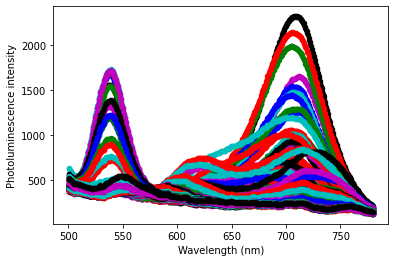

In [ ]:
## Without baselinecorrection/normalization
PL_plot(PL_df)

In [ ]:
## Baseline corrections for all datapoints

def baseline_corr(df):
  y_columns = df.columns[1:]
  for y_col in y_columns:
    df[y_col] = df[y_col] - airPLS(df[y_col])
  return df

In [ ]:
baseline_corr(PL_df)

WARING max iteration reached!


,wavelength,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97
0,500.214600,38.702405,32.625265,27.779236,25.162149,40.363254,39.356165,39.041718,45.334317,44.361880,44.303079,33.223298,39.760810,41.229228,40.761989,46.652215,46.024311,43.067464,31.530472,45.115980,39.845055,37.889439,30.696952,30.387328,39.996981,35.276402,42.689220,45.188639,40.084791,48.272813,38.686186,35.612329,38.553175,43.696306,35.078435,41.831171,55.432686,52.078950,47.772598,50.085884,...,38.403279,43.290140,34.788298,34.354907,40.415959,37.306665,39.469199,30.309524,32.186238,32.575245,30.881226,38.121487,35.718675,31.589212,36.890093,40.054270,31.974832,43.156463,39.169350,41.953569,51.262012,32.263874,28.475409,28.843261,43.461018,74.743857,37.139990,21.556553,15.171316,21.665480,11.768383,8.531779,15.760449,36.349326,23.308575,35.381719,34.797935,61.371536,56.073403,68.707636
1,500.800598,34.009202,28.273563,25.940039,21.495465,35.388453,34.765035,33.513554,38.614708,39.143947,39.697125,27.289507,33.358553,36.538630,34.810247,39.449076,41.172794,38.381294,27.461227,40.237513,36.363538,32.930311,27.574142,27.170666,35.363656,30.888285,38.748164,38.886009,36.023857,43.181468,34.677090,34.243591,33.819313,41.425512,30.365878,38.089108,49.295681,44.181346,43.551265,43.827054,...,34.415723,40.039090,29.969623,30.049121,37.330304,33.931947,34.526061,26.704595,30.388097,28.930335,27.401343,33.690315,32.362735,26.508419,34.267782,36.375360,28.314933,38.468505,37.113268,38.116166,43.832752,23.197140,22.296582,22.084087,34.177044,63.177455,26.183348,14.762851,9.207491,12.712811,5.481625,2.813585,11.005201,28.336426,16.051231,26.926538,26.323073,50.983877,48.443015,58.233658
2,501.386536,29.739430,27.921832,23.606335,20.084793,33.706254,32.856736,31.473152,36.134509,36.578969,35.331681,25.123965,32.512784,34.622875,31.541365,36.295803,37.242482,34.962305,24.048262,37.497596,34.930695,30.623008,27.070992,26.751000,34.955307,27.232926,36.104136,36.894811,34.193452,41.108830,33.160975,33.753515,30.357852,38.937006,27.774812,34.772461,44.792679,39.173848,42.133459,38.382890,...,32.790501,37.976332,27.781624,29.793141,35.252339,31.348732,29.142677,24.401150,29.493428,27.538142,25.555554,31.973102,30.749563,26.173721,33.239710,36.462532,25.713751,35.742828,35.706814,38.290971,40.341388,18.996250,17.398242,17.752801,27.512759,51.839446,20.407371,12.127656,5.327896,9.160288,3.296106,1.345969,7.164565,22.161599,14.414707,22.017805,20.419133,44.436550,42.117467,51.012426
3,501.972443,28.890099,27.798554,23.217516,19.846119,32.691596,31.615979,29.149029,33.083968,33.323226,32.443166,24.984028,30.072288,34.016384,29.232689,33.515820,34.255559,32.504986,22.964368,35.557728,32.515767,29.163056,26.937959,24.506200,34.557303,26.081748,35.334558,37.880329,33.057658,38.866606,31.148033,33.921490,29.075040,39.257857,26.566070,32.357089,41.545017,37.624511,39.746538,35.921117,...,31.937405,37.470704,29.259213,28.602376,36.303646,32.621963,26.559219,23.981524,27.923283,26.215986,23.523638,28.743560,30.691170,25.852694,32.257231,36.544975,25.644489,34.498779,35.995429,36.092179,39.819416,15.836437,12.662927,13.997656,23.502314,42.961642,16.090194,9.387176,3.250048,6.773842,3.451126,0.399774,4.165583,17.276263,13.040267,18.055667,16.047084,40.200136,37.954944,46.300228
4,502.558350,27.580166,26.305709,22.427086,18.394554,29.087858,29.005653,26.138260,29.585581,30.106148,27.864190,23.094640,27.964464,32.107097,25.969088,31.196837,32.380513,30.189055,20.776623,32.532045,28.190988,27.399028,23.150476,20.269456,32.060697,23.778104,31.876046,35.242311,31.362568,35.391045,28.697134,32.367023,25.673789,36.182040,23.393370,26.318732,36.136162,35.708567,34.458035,33.110804,...,29.553455,32.966968,27.282854,29.844473,34.966221,31.412711,26.650017,21.467171,26.204396,26.022249,22.073356,26.322825,30.471126,22.544

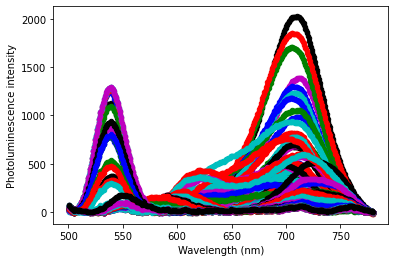

In [ ]:
PL_plot(PL_df)

In [ ]:
## Example of how to implement the baseline corrections
# if __name__=='__main__':
#     '''
#     Example usage and testing
#     '''
#     print('Testing...')
#     from scipy.stats import norm
#     import matplotlib.pyplot as pl
#     x=np.arange(0,1000,1)
#     g1=norm(loc = 100, scale = 1.0) # generate three gaussian as a signal
#     g2=norm(loc = 300, scale = 3.0)
#     g3=norm(loc = 750, scale = 5.0)
#     signal=g1.pdf(x)+g2.pdf(x)+g3.pdf(x)
#     baseline1=5e-4*x+0.2 # linear baseline
#     baseline2=0.2*np.sin(np.pi*x/x.max()) # sinusoidal baseline
#     noise=np.random.random(x.shape[0])/500
#     print('Generating simulated experiment')
#     y1=signal+baseline1+noise
#     y2=signal+baseline2+noise
#     print('Removing baselines') 
#     c1=y1-airPLS(y1) # corrected values
#     c2=y2-airPLS(y2) # with baseline removed
#     print('Plotting results')
#     fig,ax=pl.subplots(nrows=2,ncols=1)
#     ax[0].plot(x,y1,'-k')
#     ax[0].plot(x,c1,'-r')
#     ax[0].set_title('Linear baseline')
#     ax[1].plot(x,y2,'-k')
#     ax[1].plot(x,c2,'-r')
#     ax[1].set_title('Sinusoidal baseline')
#     pl.show()
#     print('Done!')

In [ ]:
PL_df

,wavelength,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97
0,500.214600,38.702405,32.625265,27.779236,25.162149,40.363254,39.356165,39.041718,45.334317,44.361880,44.303079,33.223298,39.760810,41.229228,40.761989,46.652215,46.024311,43.067464,31.530472,45.115980,39.845055,37.889439,30.696952,30.387328,39.996981,35.276402,42.689220,45.188639,40.084791,48.272813,38.686186,35.612329,38.553175,43.696306,35.078435,41.831171,55.432686,52.078950,47.772598,50.085884,...,38.403279,43.290140,34.788298,34.354907,40.415959,37.306665,39.469199,30.309524,32.186238,32.575245,30.881226,38.121487,35.718675,31.589212,36.890093,40.054270,31.974832,43.156463,39.169350,41.953569,51.262012,32.263874,28.475409,28.843261,43.461018,74.743857,37.139990,21.556553,15.171316,21.665480,11.768383,8.531779,15.760449,36.349326,23.308575,35.381719,34.797935,61.371536,56.073403,68.707636
1,500.800598,34.009202,28.273563,25.940039,21.495465,35.388453,34.765035,33.513554,38.614708,39.143947,39.697125,27.289507,33.358553,36.538630,34.810247,39.449076,41.172794,38.381294,27.461227,40.237513,36.363538,32.930311,27.574142,27.170666,35.363656,30.888285,38.748164,38.886009,36.023857,43.181468,34.677090,34.243591,33.819313,41.425512,30.365878,38.089108,49.295681,44.181346,43.551265,43.827054,...,34.415723,40.039090,29.969623,30.049121,37.330304,33.931947,34.526061,26.704595,30.388097,28.930335,27.401343,33.690315,32.362735,26.508419,34.267782,36.375360,28.314933,38.468505,37.113268,38.116166,43.832752,23.197140,22.296582,22.084087,34.177044,63.177455,26.183348,14.762851,9.207491,12.712811,5.481625,2.813585,11.005201,28.336426,16.051231,26.926538,26.323073,50.983877,48.443015,58.233658
2,501.386536,29.739430,27.921832,23.606335,20.084793,33.706254,32.856736,31.473152,36.134509,36.578969,35.331681,25.123965,32.512784,34.622875,31.541365,36.295803,37.242482,34.962305,24.048262,37.497596,34.930695,30.623008,27.070992,26.751000,34.955307,27.232926,36.104136,36.894811,34.193452,41.108830,33.160975,33.753515,30.357852,38.937006,27.774812,34.772461,44.792679,39.173848,42.133459,38.382890,...,32.790501,37.976332,27.781624,29.793141,35.252339,31.348732,29.142677,24.401150,29.493428,27.538142,25.555554,31.973102,30.749563,26.173721,33.239710,36.462532,25.713751,35.742828,35.706814,38.290971,40.341388,18.996250,17.398242,17.752801,27.512759,51.839446,20.407371,12.127656,5.327896,9.160288,3.296106,1.345969,7.164565,22.161599,14.414707,22.017805,20.419133,44.436550,42.117467,51.012426
3,501.972443,28.890099,27.798554,23.217516,19.846119,32.691596,31.615979,29.149029,33.083968,33.323226,32.443166,24.984028,30.072288,34.016384,29.232689,33.515820,34.255559,32.504986,22.964368,35.557728,32.515767,29.163056,26.937959,24.506200,34.557303,26.081748,35.334558,37.880329,33.057658,38.866606,31.148033,33.921490,29.075040,39.257857,26.566070,32.357089,41.545017,37.624511,39.746538,35.921117,...,31.937405,37.470704,29.259213,28.602376,36.303646,32.621963,26.559219,23.981524,27.923283,26.215986,23.523638,28.743560,30.691170,25.852694,32.257231,36.544975,25.644489,34.498779,35.995429,36.092179,39.819416,15.836437,12.662927,13.997656,23.502314,42.961642,16.090194,9.387176,3.250048,6.773842,3.451126,0.399774,4.165583,17.276263,13.040267,18.055667,16.047084,40.200136,37.954944,46.300228
4,502.558350,27.580166,26.305709,22.427086,18.394554,29.087858,29.005653,26.138260,29.585581,30.106148,27.864190,23.094640,27.964464,32.107097,25.969088,31.196837,32.380513,30.189055,20.776623,32.532045,28.190988,27.399028,23.150476,20.269456,32.060697,23.778104,31.876046,35.242311,31.362568,35.391045,28.697134,32.367023,25.673789,36.182040,23.393370,26.318732,36.136162,35.708567,34.458035,33.110804,...,29.553455,32.966968,27.282854,29.844473,34.966221,31.412711,26.650017,21.467171,26.204396,26.022249,22.073356,26.322825,30.471126,22.544

In [ ]:
## There is a few number of negative values after baseline corrections at the end of datasets(after 770nm)
## let's assign zero to them that it won't affect the normalization
PL_df[PL_df < 0] = 0

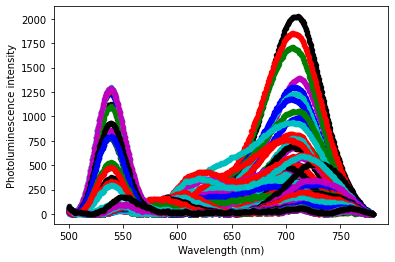

In [ ]:
PL_plot(PL_df)

In [ ]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns[1:]:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [ ]:
normalize_PL_df  = normalize(PL_df)

In [ ]:
normalize_PL_df

0.0

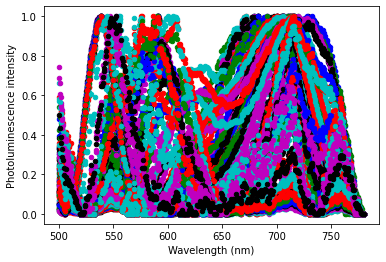

In [ ]:
PL_plot(normalize_PL_df)

PL spectra is given as intensity vs wavelength
we should use E=hc/lambda to convert wavelength to energy (hc = 1240)

In [ ]:
## Convert Wavelength column to photon energy
PL_df.rename(columns={'wavelength': 'Energy(eV)'}, inplace=True)
PL_df['Energy(eV)'] = 1240.0/PL_df['Energy(eV)'] 
PL_df

,Energy(eV),1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97
0,2.478936,38.702405,32.625265,27.779236,25.162149,40.363254,39.356165,39.041718,45.334317,44.361880,44.303079,33.223298,39.760810,41.229228,40.761989,46.652215,46.024311,43.067464,31.530472,45.115980,39.845055,37.889439,30.696952,30.387328,39.996981,35.276402,42.689220,45.188639,40.084791,48.272813,38.686186,35.612329,38.553175,43.696306,35.078435,41.831171,55.432686,52.078950,47.772598,50.085884,...,38.403279,43.290140,34.788298,34.354907,40.415959,37.306665,39.469199,30.309524,32.186238,32.575245,30.881226,38.121487,35.718675,31.589212,36.890093,40.054270,31.974832,43.156463,39.169350,41.953569,51.262012,32.263874,28.475409,28.843261,43.461018,74.743857,37.139990,21.556553,15.171316,21.665480,11.768383,8.531779,15.760449,36.349326,23.308575,35.381719,34.797935,61.371536,56.073403,68.707636
1,2.476035,34.009202,28.273563,25.940039,21.495465,35.388453,34.765035,33.513554,38.614708,39.143947,39.697125,27.289507,33.358553,36.538630,34.810247,39.449076,41.172794,38.381294,27.461227,40.237513,36.363538,32.930311,27.574142,27.170666,35.363656,30.888285,38.748164,38.886009,36.023857,43.181468,34.677090,34.243591,33.819313,41.425512,30.365878,38.089108,49.295681,44.181346,43.551265,43.827054,...,34.415723,40.039090,29.969623,30.049121,37.330304,33.931947,34.526061,26.704595,30.388097,28.930335,27.401343,33.690315,32.362735,26.508419,34.267782,36.375360,28.314933,38.468505,37.113268,38.116166,43.832752,23.197140,22.296582,22.084087,34.177044,63.177455,26.183348,14.762851,9.207491,12.712811,5.481625,2.813585,11.005201,28.336426,16.051231,26.926538,26.323073,50.983877,48.443015,58.233658
2,2.473142,29.739430,27.921832,23.606335,20.084793,33.706254,32.856736,31.473152,36.134509,36.578969,35.331681,25.123965,32.512784,34.622875,31.541365,36.295803,37.242482,34.962305,24.048262,37.497596,34.930695,30.623008,27.070992,26.751000,34.955307,27.232926,36.104136,36.894811,34.193452,41.108830,33.160975,33.753515,30.357852,38.937006,27.774812,34.772461,44.792679,39.173848,42.133459,38.382890,...,32.790501,37.976332,27.781624,29.793141,35.252339,31.348732,29.142677,24.401150,29.493428,27.538142,25.555554,31.973102,30.749563,26.173721,33.239710,36.462532,25.713751,35.742828,35.706814,38.290971,40.341388,18.996250,17.398242,17.752801,27.512759,51.839446,20.407371,12.127656,5.327896,9.160288,3.296106,1.345969,7.164565,22.161599,14.414707,22.017805,20.419133,44.436550,42.117467,51.012426
3,2.470255,28.890099,27.798554,23.217516,19.846119,32.691596,31.615979,29.149029,33.083968,33.323226,32.443166,24.984028,30.072288,34.016384,29.232689,33.515820,34.255559,32.504986,22.964368,35.557728,32.515767,29.163056,26.937959,24.506200,34.557303,26.081748,35.334558,37.880329,33.057658,38.866606,31.148033,33.921490,29.075040,39.257857,26.566070,32.357089,41.545017,37.624511,39.746538,35.921117,...,31.937405,37.470704,29.259213,28.602376,36.303646,32.621963,26.559219,23.981524,27.923283,26.215986,23.523638,28.743560,30.691170,25.852694,32.257231,36.544975,25.644489,34.498779,35.995429,36.092179,39.819416,15.836437,12.662927,13.997656,23.502314,42.961642,16.090194,9.387176,3.250048,6.773842,3.451126,0.399774,4.165583,17.276263,13.040267,18.055667,16.047084,40.200136,37.954944,46.300228
4,2.467375,27.580166,26.305709,22.427086,18.394554,29.087858,29.005653,26.138260,29.585581,30.106148,27.864190,23.094640,27.964464,32.107097,25.969088,31.196837,32.380513,30.189055,20.776623,32.532045,28.190988,27.399028,23.150476,20.269456,32.060697,23.778104,31.876046,35.242311,31.362568,35.391045,28.697134,32.367023,25.673789,36.182040,23.393370,26.318732,36.136162,35.708567,34.458035,33.110804,...,29.553455,32.966968,27.282854,29.844473,34.966221,31.412711,26.650017,21.467171,26.204396,26.022249,22.073356,26.322825,30.471126,22.544546,29.720

In [ ]:
# ## Return the index of maximum value
# idx = PL_df[[4]].idxmax()
# idx

4    315
dtype: int64

In [ ]:
# index_m = PL_df.idxmax()
# print(index_m)
# #PL_df.loc[index_m,'Energy(eV)']

Energy(eV)      0
1             355
2             308
3             308
4             315
             ... 
93             66
94             66
95             75
96             90
97             90
Length: 98, dtype: int64


In [ ]:
# i = PL_df[1].argmax()
# PL_df["Energy(eV)"].iloc[i]

1.7563712045226116

In [ ]:
# print(PL_df["Energy(eV)"].iloc[idx])

355    1.756371
Name: Energy(eV), dtype: float64


In [ ]:
# PL_df.loc[idx,'Energy(eV)'] 


pandas.core.series.Series

In [ ]:
# ## Verify that the max index is in the range
# PL_df.iloc[300:310]

,Energy(eV),1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97
300,1.838594,135.120386,169.520449,335.306441,323.280446,35.274993,46.796928,44.217727,2.379795,28.230823,29.568847,74.764697,57.175875,267.862203,227.003464,212.309931,215.243591,193.900238,207.102332,218.274420,239.100801,166.107964,167.618675,269.643788,212.769834,207.377403,284.721448,243.744553,243.037414,227.075578,546.036456,948.339423,664.269352,966.530206,1038.779912,672.885242,342.436836,294.865267,523.737023,381.814302,...,377.752606,312.205160,45.543593,42.087293,32.741664,38.925536,37.208438,17.547900,30.939846,12.782001,19.606122,0.000000,1.187097,13.380400,4.584995,9.124371,8.067538,11.501968,3.958553,1.561875,16.810315,9.828567,19.781730,13.311361,16.011758,10.193832,8.946502,15.564819,10.845333,12.533964,8.038669,9.731148,15.387292,8.523217,11.381312,7.474712,9.089585,17.688941,17.594145,11.371623
301,1.837027,139.161586,172.874630,335.186311,326.989126,39.303059,48.935672,46.835254,2.865552,33.027942,30.319371,78.045264,59.554629,270.797505,229.657817,216.417197,217.101883,194.234704,209.310014,220.901597,240.962845,169.139499,172.458398,274.600386,217.442427,211.235729,292.148769,248.633838,248.327488,233.015514,562.998528,970.995189,680.071107,985.480363,1059.304806,687.395823,353.073701,301.990757,532.370610,389.661075,...,383.317036,316.603403,52.108483,45.213283,35.300827,41.318132,40.900276,20.125312,31.085753,14.732738,21.302646,3.423136,2.333832,13.789337,6.678507,10.809662,9.383157,10.795160,3.956541,2.432892,17.285503,12.051274,22.399697,13.843019,18.339266,12.736824,9.834186,16.135266,12.141468,13.690778,9.424704,10.366924,17.046243,10.392603,13.353361,9.743389,12.227975,19.705083,18.949170,11.565234
302,1.835464,140.519894,173.033712,336.139362,326.673453,40.940896,48.537810,47.501564,3.746519,33.898226,29.630855,81.008784,61.591921,272.245015,228.751227,215.451282,216.838195,193.544817,210.054316,222.065335,242.824889,169.756392,175.956660,277.239907,221.090637,212.874542,297.722391,253.059682,252.227302,237.370061,577.326505,991.480057,692.214354,1001.357400,1078.073474,698.174775,361.003229,310.555212,538.126085,396.312779,...,385.661985,318.416319,54.697756,46.607582,34.713629,42.052188,41.470135,21.336879,32.060913,14.512744,21.950373,2.049671,0.724494,13.100708,6.601287,9.616901,7.747574,9.722491,4.247206,2.304183,17.224115,11.542292,21.578639,13.277128,16.496058,13.889572,8.917014,15.315455,9.803447,13.408551,8.493662,8.197844,15.680796,9.432721,15.130280,9.548671,11.488329,19.940754,15.816387,10.636881
303,1.833903,143.414762,174.973281,335.141241,328.626029,43.042127,49.139964,49.826398,4.299854,34.353883,30.283814,86.216200,63.775545,276.960774,231.990938,216.534165,217.111098,194.806132,211.481510,221.643683,246.052778,171.226954,178.869533,281.952609,223.738846,217.732867,301.930168,258.558708,257.492993,242.017303,589.776431,1016.135824,706.235591,1019.234315,1099.598367,710.856131,368.786457,318.095313,549.003569,402.427863,...,389.421545,321.399889,57.896800,48.928732,38.638607,43.444784,43.918077,23.377701,33.840975,15.219570,23.183487,2.135818,1.195617,12.924272,6.304555,10.765601,7.868079,10.869335,4.318359,3.076958,19.187110,11.765000,21.099057,13.881952,16.043093,14.237435,9.048610,16.251762,11.221546,12.614117,6.977263,8.321428,15.559245,12.277708,14.516955,11.475886,12.016963,20.225206,17.049464,12.293901
304,1.832344,143.943755,175.059181,336.582085,327.822502,44.826296,50.083578,50.809770,4.799442,34.443681,30.156287,88.618715,65.251864,279.871663,232.840420,213.982892,218.042540,195.774754,211.323347,221.392809,248.280636,170.648748,180.270231,287.079983,225.533387,219.615607,306.089179,260.033319,260.685502,244.859643,600.494606,1038.718349,721.330071,1038.111352,1116.440278,723.488660,375.716046,323.830483,557.856639,408.299050,...

In [ ]:
## Find the peak(bandgap)
def peak_find(df):
  band_gap = []
  y_columns = df.columns[1:]
  for y_col in y_columns:
    ## Return the index of maximum value
    idx = PL_df[y_col].argmax()
    bandgap = PL_df["Energy(eV)"].iloc[idx]
    band_gap.append(bandgap)
    
  return band_gap

In [ ]:
## Exporting bandgaps as a new dataframe
results = peak_find(PL_df)
dict = {}
for i,y_col in enumerate(y_columns):
  dict[y_col] = results[i]

PL_result = pd.DataFrame.from_dict(dict, orient='index').rename(columns={0:'Bandgap'})

,Bandgap
1,1.756371
2,1.815384
3,1.826139
4,1.815384
5,1.736650
...,...
93,2.301337
94,2.301337
95,2.279120
96,2.243055


In [ ]:
PL_result.to_excel('/content/drive/MyDrive/UV-Vis-to-Tauc/2DayPL_Bandgap_results.xlsx')

## XRD 

In [ ]:
## Reading the input file for XRD
XRD_df = pd.read_csv('/content/drive/MyDrive/UV-Vis-to-Tauc/PXRD.csv')

In [ ]:
XRD_df

,2Tet,sce1,sce2,sce3,sce4,sce5,sce6,sce7,sce8,sce9,sce10,sce11,sce12,sce13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,10.023530,1525,1553,1524,1608,1589,1575,1528,1503,1494,1569,1580,1517,1469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10.049791,1640,1590,1492,1601,1561,1603,1531,1542,1512,1617,1559,1508,1478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.076051,1586,1556,1583,1646,1546,1604,1456,1565,1579,1548,1557,1529,1492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10.102312,1576,1543,1467,1530,1620,1565,1626,1570,1522,1637,1559,1506,1532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10.128573,1553,1513,1488,1468,1525,1629,1548,1607,1537,1563,1652,1536,1457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,39.881793,879,740,677,756,781,820,799,636,835,708,818,816,754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1138,39.908054,827,715,650,799,849,816,773,670,791,721,790,814,747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1139,39.934314,837,728,678,772,799,767,788,634,786,755,767,819,754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1140,39.960575,823,719,692,728,759,849,736,667,812,730,815,773,783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


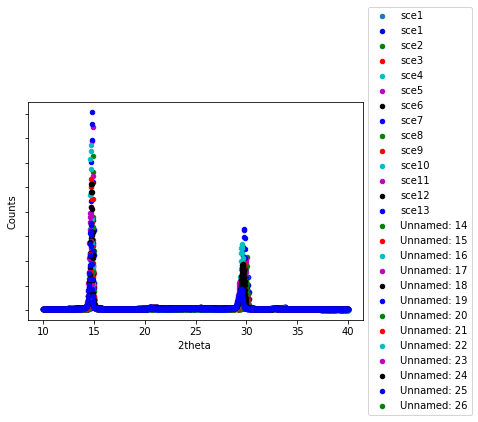

In [ ]:
## Create XRD plot for all the columns
XRD_y_columns = XRD_df.columns[1:]
from itertools import cycle
cycol = cycle('bgrcmk')
ax = XRD_df.plot.scatter(x="2Tet", y="sce1", label="sce1")
for XRD_y_col in XRD_y_columns:
    XRD_df.plot.scatter(x = "2Tet", y = XRD_y_col, label="{}".format(XRD_y_col), c=next(cycol), ax=ax);
    ax.set_xlabel("2theta ")
    ax.set_ylabel("Counts")
    # Turn off tick labels
    ax.set_yticklabels([])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

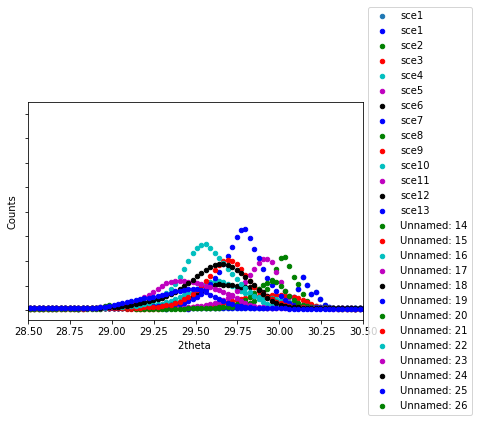

In [ ]:
## Create portion of XRD plot for all the columns
XRD_y_columns = XRD_df.columns[1:]
from itertools import cycle
cycol = cycle('bgrcmk')
ax = XRD_df.plot.scatter(x="2Tet", y="sce1", label="sce1")
for XRD_y_col in XRD_y_columns:
    XRD_df.plot.scatter(x = "2Tet", y = XRD_y_col, label="{}".format(XRD_y_col), c=next(cycol), ax=ax);
    ax.set_xlim([28.5, 30.5])
    ax.set_xlabel("2theta ")
    ax.set_ylabel("Counts")
    # Turn off tick labels
    ax.set_yticklabels([])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))






ValueError: ignored

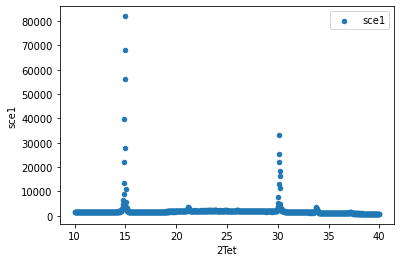

In [ ]:
## Create portion of XRD plot for all the columns
XRD_y_columns = XRD_df.columns[1:]
from itertools import cycle
cycol = cycle('bgrcmk')
ax = XRD_df.plot.scatter(x="2Tet", y="sce1", label="sce1")
for XRD_y_col in XRD_y_columns:
    XRD_df.plot.scatter(x = "2Tet", y = XRD_y_col, label="{}".format(XRD_y_col), c=next(cycol), ax=ax);
    ax.set_xlim([28.5, 30.5])
    ax.set_xlabel("2theta ")
    ax.set_ylabel("Counts")
    # Turn off tick labels
    ax.set_yticklabels([])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
